# Imports & Helper Functions

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import style
import seaborn as sns
from pylab import rcParams
from tqdm import tnrange, tqdm_notebook, tqdm
import time
plt.style.use('ggplot')
sns.set_style('darkgrid')

import scipy.stats as stats
from scipy.optimize import minimize
import scipy.spatial.distance as dist
import scipy.cluster.hierarchy as sch
from datetime import date
from sklearn.externals import joblib

In [2]:
def to_percent(x):
    try: f_string = '{:.0%}'.format(x)
    except: f_string = x
    return f_string

def to_decimal(x):
    try:
        if x >= 100:
            f_string = '{0:,.0f}'.format(x)
        elif x >= 10:
            f_string = '{0:,.1f}'.format(x)
        else:
            f_string = '{0:,.2f}'.format(x)
            
    except: f_string = x
    return f_string

def max_drawdown(df_returns):
    max_dd = (np.cumprod(1+df_returns)/np.maximum.accumulate(np.cumprod(1+df_returns))-1).min()
    return max_dd

In [3]:
def to_summary(df_returns):
    # Daily return calcs
    df_summary = pd.DataFrame(columns=df_returns.columns)
    df_summary.loc['Summary Stats:'] = ''
    MOIC = np.prod(1+df_returns)
    CAGR = MOIC**(periodicity/len(df_returns))-1
    df_summary.loc['CAGR'] = CAGR.apply(to_percent)
    df_summary.loc['MOIC'] = MOIC
    df_summary.loc['Sharpe'] = CAGR/(np.std(df_returns)*np.sqrt(periodicity))
    df_summary.loc['Sortino'] = CAGR/(np.std(np.clip(df_returns, a_max=0, a_min=None))*np.sqrt(periodicity))
    df_summary.loc['Skew'] = stats.skew(df_returns, bias=True)
    df_summary.loc['Max Drawdown'] = max_drawdown(df_returns).apply(to_percent)
    df_summary.loc['Ulcer Index'] = np.sqrt(np.sum((np.cumprod(1+df_returns)\
                                                    /np.maximum.accumulate(np.cumprod(1+df_returns))-1)**2)\
                                            /len(df_returns))*100
    
    df_summary.loc['Ulcer Performance Index'] = CAGR/df_summary.loc['Ulcer Index']*100
    df_summary = df_summary.applymap(to_decimal)
    df_summary.loc['MOIC', :] = df_summary.loc['MOIC', :]+str('x')
    
    # Monthly return calcs
    df_summary.loc['Monthly Perf. Metrics:'] = ''
    df_months = pd.DataFrame(columns=df_returns.columns)
    df_returnsM = (1+df_returns).resample('M').prod()-1
    MOIC_M = np.prod(1+df_returnsM)
    CAGR_M = MOIC_M**(12/len(df_returnsM))-1
    df_months.loc['Sharpe'] = CAGR_M/(np.std(df_returnsM)*np.sqrt(12))
    df_months.loc['Sortino'] = CAGR_M/(np.std(np.clip(df_returnsM, a_max=0, a_min=None))*np.sqrt(12))
    
    if len(df_returnsM) >= 36: df_months.loc['Calmar'] = -(np.prod(1+df_returnsM.iloc[-12*3:])**(1/3)-1)\
                                                         / max_drawdown(df_returnsM.iloc[-12*3:])
    
    df_months.loc['Gain to Pain Ratio'] = -np.sum(df_returnsM)/np.sum(np.clip(df_returnsM, a_max=0, a_min=None))
    
    df_months.loc['Upside Beta'] = df_returnsM[df_returnsM.iloc[:, 0]>0].cov().iloc[0, :]\
                                 / df_returnsM[df_returnsM.iloc[:, 0]>0].cov().iloc[0, 0]
    
    df_months.loc['Downside Beta'] = df_returnsM[df_returnsM.iloc[:, 0]<0].cov().iloc[0, :]\
                                   / df_returnsM[df_returnsM.iloc[:, 0]<0].cov().iloc[0, 0]
    
    df_months = df_months.applymap(to_decimal)
    df_summary = df_summary.append(df_months)
    
    # Annuals
    df_summary.loc['Annual Returns:'] = ''
    df_annuals = df_returns.groupby(df_returns.index.year).apply(lambda x: np.prod(1+x)-1).applymap(to_percent)
    df_summary = df_summary.append(df_annuals)

    # Drawdowns
    df_summary.loc['Annual Max DD:'] = ''    
    df_maxdd = df_returns.groupby(df_returns.index.year).apply(max_drawdown).applymap(to_percent)
    df_summary = df_summary.append(df_maxdd)
    return df_summary

In [4]:
def numpy_ewm(data, window, method=None):
    """
    Calculates exponential weighted moving average on 2x2 numpy array.
    Choose 'halflife', 'com', or 'span' methods.
    Modified to fit 2d array from stackoverflow answer at https://stackoverflow.com/a/42926270/8678259
    """
    if method == 'halflife': alpha = 1-np.exp(np.log(0.5)/window)
    elif method == 'com': alpha = 1/(1+window)
    else: alpha = 2/(1+window)

    alpha_rev = 1-alpha
    n = data.shape[0]

    pows = alpha_rev**(np.arange(n+1))
    scale_arr = 1/pows[:-1]
    offset = data[0].reshape(1, -1)*pows[1:].reshape(-1, 1)
    pw0 = alpha*alpha_rev**(n-1)

    mult = data*pw0*scale_arr.reshape(-1, 1)
    cumsums = mult.cumsum(axis=0)
    out = offset + cumsums*scale_arr[::-1].reshape(-1, 1)
    return out

### Global Minimum Variance Portfolio

In [5]:
#-------------------------------------
# Global minimum variance portfolio
# Pages 7-8 of https://faculty.washington.edu/ezivot/econ424/portfolioTheoryMatrix.pdf
#-------------------------------------
def min_var(returns_array, MV_lambda):
    n_ticks = returns_array.shape[1]
    A = np.zeros([n_ticks+1, n_ticks+1])
    A[:-1, :-1] = 2*np.cov(returns_array.T)
    A[-1, 0:-1] = 1
    A[0:-1, -1] = 1
    z0 = np.zeros([n_ticks+1, 1])
    z0[-1] = MV_lambda
    b = np.zeros([n_ticks+1, 1])
    b[-1] = 1
    z = np.linalg.inv(A) @ b
    return z[:-1]

MV_lambda = 0.5

### Equal Risk Contribution

In [6]:
#-------------------------------------
# Newton method ERC weight calc
# per page 7 of
# http://www.top1000funds.com/wp-content/uploads/2012/08/Efficient-algorithms-for-computing-risk-parity-portfolio-weights.pdf
#-------------------------------------
def get_F(omega, y):
    x = y[:-1]
    newt_lambda = y[-1]
    F = np.zeros([len(x)+1, 1])
    F[:-1] = omega @ x - (newt_lambda*(1/x))
    F[-1] = x.sum()-1
    return F

def get_J(omega, y):
    x = y[:-1]
    newt_lambda = y[-1]
    J = np.zeros([len(x)+1, len(x)+1])
    J[:-1, :-1] = omega + newt_lambda*np.diagflat(1/np.square(x))
    J[:-1, -1] = -1/x.ravel()
    J[-1, :-1] = 1
    return J

def getERCWeights(omega, y, epsilon):
    y_last = y
    y_next = y_last - (np.linalg.inv(get_J(omega, y_last)) @ get_F(omega, y_last))
    condition = np.linalg.norm(y_next - y_last, ord=2)
    
    while condition > epsilon:
        y_last = y_next
        y_next = y_last - (np.linalg.inv(get_J(omega, y_last)) @ get_F(omega, y_last))
        condition = np.linalg.norm(y_next - y_last, ord=2)
    
    return y_next[:-1]
    
newt_lambda0 = 0.5
eps = 10**-8

### Diversified Risk Parity

In [7]:
"""
Diversified Risk Parity
Based on Harald Lohre's paper:
http://www.northinfo.com/documents/515.pdf
https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1974446

Weights are determined so that each eigenvector of the covariance matrix contributes equally to portfolio risk.
"""
def getDiversifiedWeights(w):
    sigma = np.cov(returns.T)
    eigvals, eigvecs = np.linalg.eig(sigma)
    eigvals = eigvals.reshape(-1, 1)
    w_tilde = eigvecs.T @ w
    v = w_tilde**2 * eigvals
    p = v/v.sum()
    N_Ent = np.exp(-np.sum(p*np.log(p)))
    return -N_Ent

### de Prado's Hierarchical Risk Parity

In [8]:
#-------------------------------------
# Hierarchical risk parity by Marcos Lopez de Prado 
# This code only taken from de Prado's paper at https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2708678
#-------------------------------------
def getIVP(cov, **kargs):
    # Compute the inverse-variance portfolio
    ivp = 1./np.diag(cov) # taking np.sqrt performs poorly
    ivp /= ivp.sum()
    return ivp

def getClusterVar(cov, cItems):
    # Compute variance per cluster
    cov_ = cov.loc[cItems, cItems] # matrix slice
    w_   = getIVP(cov_).reshape(-1, 1)
    cVar = np.dot(np.dot(w_.T, cov_), w_)[0, 0] # taking np.sqrt performs poorly
    return cVar

def getQuasiDiag(link):
    # Sort clustered items by distance
    link = link.astype(int)
    sortIx = pd.Series([link[-1, 0], link[-1, 1]])
    numItems = link[-1, 3]  # number of original items
    
    while sortIx.max() >= numItems:
        sortIx.index = range(0, sortIx.shape[0]*2, 2)  # make space
        df0 = sortIx[sortIx >= numItems]  # find clusters
        i = df0.index
        j = df0.values - numItems
        sortIx[i] = link[j, 0]  # item 1
        df0 = pd.Series(link[j, 1], index=i + 1)
        sortIx = sortIx.append(df0)  # item 2
        sortIx = sortIx.sort_index()  # re-sort
        sortIx.index = range(sortIx.shape[0])  # re-index

    return sortIx.tolist()

def getRecBipart(cov, sortIx):
    # Compute HRP alloc
    w = pd.Series(1, index=sortIx)
    cItems = [sortIx]  # initialize all items in one cluster
    while len(cItems) > 0:
        cItems = [i[j:k] for i in cItems for j, k in ((0, len(i)//2),
                                                      (len(i)//2, len(i))) if len(i) > 1]  # bi-section
        for i in range(0, len(cItems), 2):  # parse in pairs
            cItems0 = cItems[i]  # cluster 1
            cItems1 = cItems[i+1]  # cluster 2
            cVar0 = getClusterVar(cov, cItems0)
            cVar1 = getClusterVar(cov, cItems1)
            alpha = 1 - cVar0/(cVar0+cVar1)
            w[cItems0] *= alpha  # weight 1
            w[cItems1] *= 1-alpha  # weight 2

    return w

def correlDist(corr):
    # A distance matrix based on correlation, where 0<=d[i,j]<=1
    # This is a proper distance metric
    dist = ((1-corr)/2.)**.5  # distance matrix
    return dist

def getHRP(cov, corr):
    # Construct a hierarchical portfolio
    corr, cov = pd.DataFrame(corr), pd.DataFrame(cov)
    dist = correlDist(corr)
    link = sch.linkage(dist, 'single')
    sortIx = getQuasiDiag(link)
    sortIx = corr.index[sortIx].tolist()
    # recover labels
    hrp = getRecBipart(cov, sortIx)
    return hrp.sort_index()

### Return & Drawdown Plot

In [9]:
def plot_rets_dd(rets_series, yscale, sizex, sizey):
    plt.style.use('ggplot')
    sns.set_style('darkgrid')
    x = rets_series.index
    y1 = np.cumprod(1+rets_series)
    y2 = np.cumprod(1+rets_series)/np.maximum.accumulate(np.cumprod(1+rets_series))-1
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(sizex, sizey), sharex=True)
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 2])
    
    ax1 = plt.subplot(gs[0])
    ax1.fill_between(x, 0, y1, facecolor=(0, 51/255, 102/255), alpha=0.35)
    #ax1.set_ylim(0, )
    ax1.set_yscale(yscale)
    ax1.set_ylabel('Cumulative MOIC', fontsize=14)
        
    ax2 = plt.subplot(gs[1])
    ax2.fill_between(x, y2, 0, facecolor=(255/255, 102/255, 0), alpha=0.35)
    ax2.set_ylim(-1, 0)
    ax2.set_ylabel('% Drawdown', fontsize=14)
    plt.suptitle(rets_series.name, fontsize=16)
    fig.subplots_adjust(hspace=0.15)

# Risk Parity Data Import & Inputs

In [10]:
df = pd.read_excel("returns_data.xlsx")
df = df.loc[:"December 2017", :]

In [11]:
#-------------------------------------
# Ticker selection and lookback input
#-------------------------------------
tickers = ['RPG', 'SVXY', 'TLT', 'GLD', 'UGAZ'] # IV solution

df_px = df[tickers].fillna(method='ffill')

lookback = 21*6
corr_lookback = 21*24
periodicity = 252

leverage = 2
margin_rate = .02768 # <-- quoted IB rate as of December 27, 2017

n_tickers = len(tickers)
N = len(df_px)

df_returns = df_px.pct_change()
df_px.tail()

,RPG,SVXY,TLT,GLD,UGAZ
2017-12-22,105.2800,129.19,124.77,120.94,54.29
2017-12-26,105.0200,129.09,125.14,121.77,53.19
2017-12-27,105.2752,128.39,126.77,122.23,58.82
2017-12-28,105.5600,130.48,126.66,122.85,70.69
2017-12-29,104.8300,128.21,126.86,123.65,72.75


In [12]:
#-------------------------------------
# Weighted arrays
#-------------------------------------
syd_array = np.arange(1, lookback+1)/np.arange(1, lookback+1).sum()
syd_array = syd_array.reshape(-1, 1)
log_array = np.log(np.arange(lookback)+1)/np.log(np.arange(lookback)+1).sum()
log_array = log_array.reshape(-1, 1)
sqrt_array = np.sqrt(np.arange(lookback)+1)/np.sqrt(np.arange(lookback)+1).sum()
sqrt_array = sqrt_array.reshape(-1, 1)

### Global Minimum Variance Portfolio

In [13]:
#-------------------------------------
# Calculate minimum variance risk parity weights
#-------------------------------------
df_returns = df_px.pct_change()

if 'UGAZ' in df_returns.columns:
    df_returns['UGAZ'] *= -1               # Adjust for short sale
    df_returns['UGAZ'] -= .065/periodicity # Adjust for borrow cost
    
returns_array = np.array(df_returns)

MV_wts_arr = np.zeros(returns_array.shape) + 1/n_tickers

for i in tqdm(range(lookback, N)): 
    returns_array_temp = returns_array[i-lookback+1:i+1, :]
    MV_wts_arr[i] = min_var(returns_array_temp, MV_lambda).T
    
df_MV_weights = pd.DataFrame(index=df_returns.index, columns=df_returns.columns, data=MV_wts_arr)
    
if 'UGAZ' in df_returns.columns:
    df_returns['UGAZ'] *= -1               # Re-adjust for short sale
    df_MV_weights['UGAZ'] *= -1

MV_returns = (df_MV_weights.shift(1)*df_returns).sum(axis=1)
df_MV_weights.tail(1)

100%|███████████████████████████████████████████████████████████████████████████| 2895/2895 [00:00<00:00, 10560.81it/s]


,RPG,SVXY,TLT,GLD,UGAZ
2017-12-29,0.61516,-0.04755,0.249885,0.176659,-0.005847


### Naive Risk Parity

In [14]:
#-------------------------------------
# Naive risk parity weight calc
#-------------------------------------
t1 = time.time()
df_returns = df_px.pct_change()

if 'UGAZ' in df_returns.columns:
    df_returns['UGAZ'] *= -1               # Adjust for short sale
    df_returns['UGAZ'] -= .065/periodicity # Adjust for borrow cost

df_RV = np.sqrt(periodicity/lookback*(np.log(1+df_returns)**2).rolling(lookback).sum())*100
arr_IV = np.array(1/df_RV)
IV_wt_arr = arr_IV/arr_IV.sum(axis=1).reshape(-1, 1)
df_IV_weights = pd.DataFrame(index=df_RV.index, columns=df_RV.columns, data=IV_wt_arr)

if 'UGAZ' in df_returns.columns:
    df_returns['UGAZ'] *= -1               # Re-adjust for short sale
    df_IV_weights['UGAZ'] *= -1

IV_returns = (df_IV_weights.shift(1)*df_returns).sum(axis=1)
print("{0:,.5f}".format(time.time()-t1), 'seconds')
df_IV_weights.tail(1)

0.01003 seconds


,RPG,SVXY,TLT,GLD,UGAZ
2017-12-29,0.325071,0.055606,0.299835,0.289442,-0.030046


### Equal Risk Contribution

In [15]:
# Calculate ERC risk parity weights
x0 = np.ones([n_tickers, 1])/n_tickers
y0 = np.append(x0, newt_lambda0).reshape(n_tickers+1, 1)
df_returns = df_px.pct_change()

if 'UGAZ' in df_returns.columns:
    df_returns['UGAZ'] *= -1               # Adjust for short sale
    df_returns['UGAZ'] -= .065/periodicity # Adjust for borrow cost

returns_array = np.array(df_returns)

ERC_wts_arr = np.zeros(returns_array.shape) + 1/n_tickers

for i in tqdm(range(corr_lookback, N)): 
    returns_array_corr = returns_array[i-corr_lookback+1:i+1, :]
    returns_array_cov  = returns_array[i-lookback+1:i+1, :]
    
    corr = np.corrcoef(returns_array_corr.T)
    cov_diag = np.diag(np.sqrt(np.var(returns_array_cov, axis=0)))
    omega = cov_diag @ corr @ cov_diag
    ERC_wts_arr[i] = getERCWeights(omega, y0, eps).T
    
df_ERC_weights = pd.DataFrame(index=df_returns.index, columns=df_returns.columns, data=ERC_wts_arr)

if 'UGAZ' in df_returns.columns:
    df_returns['UGAZ'] *= -1               # Re-adjust for short sale
    df_ERC_weights['UGAZ'] *= -1
    df_ERC_weights['UGAZ'] = np.minimum(df_ERC_weights['UGAZ'], 0) # UGAZ weight must be negative
    
    # Set weights to max of zero
    df_ERC_weights.loc[:, df_ERC_weights.columns != 'UGAZ'] = np.maximum(
        df_ERC_weights.loc[:, df_ERC_weights.columns != 'UGAZ'], 0)

ERC_returns = (df_ERC_weights.shift(1)*df_returns).sum(axis=1)
df_ERC_weights.tail(1)

100%|████████████████████████████████████████████████████████████████████████████| 2517/2517 [00:02<00:00, 1166.99it/s]


,RPG,SVXY,TLT,GLD,UGAZ
2017-12-29,0.307808,0.054362,0.298819,0.309143,-0.029868


In [16]:
#-------------------------------------
# Trend weight calcs
#-------------------------------------
# Create dictionary of momentum dataframes
ewma_days = [21, 50, 150, 200] # List of exponential weighted moving average periods

ewma_dict = {}
momo_dict = {}
df_momo_avg = pd.DataFrame(index=df_px.index, columns=df_px.columns, data=0)

for days in ewma_days:
    ewma_dict[str(days)] = df_px.ewm(min_periods=0, halflife=days, adjust=True).mean()
    momo_dict[str(days)] = (df_px > ewma_dict[str(days)])*2-1
    df_momo_avg += momo_dict[str(days)]

df_momo_avg /= len(ewma_days)

if 'UGAZ' in df_returns.columns:
    df_momo_avg['UGAZ'] = 1
    df_momo_avg['UGAZ'] *= -1
    df_momo_avg['UGAZ'] = np.maximum(df_momo_avg['UGAZ'], 0)

df_momo_weights = df_ERC_weights*df_momo_avg
ERC_M_returns = (df_momo_weights.shift(1)*df_returns).sum(axis=1)
ERC_plus_M_returns = 0.5*ERC_returns + 0.5*ERC_M_returns

### Inverse Beta

In [17]:
#-------------------------------------
# Inverse beta weight calc
#-------------------------------------
df_returns = df_px.pct_change()

if 'UGAZ' in df_returns.columns:
    df_returns['UGAZ'] *= -1               # Adjust for short sale
    df_returns['UGAZ'] -= .065/periodicity # Adjust for borrow cost

returns_array = np.array(df_returns)
returns_array = np.append(returns_array, np.zeros([len(returns_array), 1]), axis=1)

IB_wts_arr = np.zeros(returns_array[:, :-1].shape) + 1/n_tickers
returns_array[1:lookback+1, -1] = (IB_wts_arr[:lookback, :]*returns_array[1:lookback+1, :-1]).sum(axis=1)

for i in tqdm(range(lookback, N)):
    returns_array[i, -1] = (IB_wts_arr[i-1]*returns_array[i, :-1]).sum()
    returns_array_temp = returns_array[i-lookback+1:i+1, :]
    betas = np.cov(returns_array_temp.T)[-1, :-1]/np.var(returns_array_temp[:, -1])
    IB_wts_arr[i] = (1/betas)/(1/betas).sum()

df_IB_weights = pd.DataFrame(index=df_returns.index, columns=df_returns.columns, data=IB_wts_arr)

if 'UGAZ' in df_returns.columns:
    df_returns['UGAZ'] *= -1               # Re-adjust for short sale
    df_IB_weights['UGAZ'] *= -1
    df_IB_weights['UGAZ'] = np.minimum(df_IB_weights['UGAZ'], 0) # UGAZ weight must be negative
    
    # Set weights to max of zero
    df_IB_weights.loc[:, df_IB_weights.columns != 'UGAZ'] = np.maximum(
        df_IB_weights.loc[:, df_IB_weights.columns != 'UGAZ'], 0)

IB_returns = (df_IB_weights.shift(1)*df_returns).sum(axis=1)
df_IB_weights.tail(1)

100%|███████████████████████████████████████████████████████████████████████████| 2895/2895 [00:00<00:00, 13492.08it/s]


,RPG,SVXY,TLT,GLD,UGAZ
2017-12-29,0.371379,0.07314,0.245552,0.282053,-0.027875


### Max Diversification

In [18]:
#---------------------------------
# Max diversification inputs and constraints
#---------------------------------
w0 = np.ones([len(tickers), 1])/len(tickers)

cons = ({"type": "eq",
         "fun": lambda x: np.array([1 - np.sum(x)])})

bnds = tuple((0*x-0.0, 0*x+1.0) for x in range(len(tickers)))
#bnds = ((0, 1), (0, 0.1), (0, 1), (0, 1), (0, .1))

In [19]:
# Max diversification
df_returns = df_px.pct_change()

if 'UGAZ' in df_returns.columns:
    df_returns['UGAZ'] *= -1               # Adjust for short sale
    df_returns['UGAZ'] -= .065/periodicity # Adjust for borrow cost

returns_array = np.array(df_returns)

DRP_wts_arr = np.zeros(returns_array.shape) + 1/n_tickers

w0 = np.ones([len(tickers), 1])/len(tickers)

returns = returns_array[1:lookback+1, :]
res = minimize(getDiversifiedWeights, w0, bounds=bnds, constraints=cons, options={"disp": False})
w_temp = res.x.reshape(-1, 1)
DRP_wts_arr[lookback, :] = res.x.reshape(1, -1)

for i in tqdm(range(lookback+1, N)):
    returns = returns_array[i-lookback+1:i+1, :]
    w_temp -= (w_temp - w0)*.20 # adjust beginning weights 20% of the way back to originals
    res = minimize(getDiversifiedWeights, w_temp, bounds=bnds, constraints=cons, options={"disp": False})
    w_temp = res.x.reshape(-1, 1)
    DRP_wts_arr[i] = w_temp.reshape(1, -1)

df_DRP_weights = pd.DataFrame(index=df_returns.index, columns=df_returns.columns, data=DRP_wts_arr)

if 'UGAZ' in df_returns.columns:
    df_returns['UGAZ'] *= -1               # Re-adjust for short sale
    df_DRP_weights['UGAZ'] *= -1
    df_DRP_weights['UGAZ'] = np.minimum(df_DRP_weights['UGAZ'], 0) # UGAZ weight must be negative
    
    # Set weights to max of zero
    df_DRP_weights.loc[:, df_DRP_weights.columns != 'UGAZ'] = np.maximum(
        df_DRP_weights.loc[:, df_DRP_weights.columns != 'UGAZ'], 0)

DRP_returns = (df_DRP_weights.shift(1)*df_returns).sum(axis=1)
df_DRP_weights.tail(1)

100%|█████████████████████████████████████████████████████████████████████████████| 2894/2894 [00:21<00:00, 133.89it/s]


,RPG,SVXY,TLT,GLD,UGAZ
2017-12-29,0.0,0.31829,0.0,0.416713,-0.264998


### de Prado's Hierarchical Risk Parity

In [20]:
df_returns = df_px.pct_change()

if 'UGAZ' in df_returns.columns:
    df_returns['UGAZ'] *= -1               # Adjust for short sale
    df_returns['UGAZ'] -= .065/periodicity # Adjust for borrow cost

returns_array = np.array(df_returns)

HRP_wts_arr = np.zeros(returns_array.shape) + 1/n_tickers

for i in tqdm(range(lookback, N)):
    returns_array_temp = returns_array[i-lookback+1:i+1, :]
    cov  = np.cov(returns_array_temp.T)
    corr = np.corrcoef(returns_array_temp.T)
    HRP_wts_arr[i] = getHRP(cov, corr)

df_HRP_weights = pd.DataFrame(index=df_returns.index, columns=df_returns.columns, data=HRP_wts_arr)

if 'UGAZ' in df_returns.columns:
    df_returns['UGAZ'] *= -1               # Re-adjust for short sale
    df_HRP_weights['UGAZ'] *= -1
    df_HRP_weights['UGAZ'] = np.minimum(df_HRP_weights['UGAZ'], 0) # UGAZ weight must be negative
    
    # Set weights to max of zero
    df_HRP_weights.loc[:, df_HRP_weights.columns != 'UGAZ'] = np.maximum(
        df_HRP_weights.loc[:, df_HRP_weights.columns != 'UGAZ'], 0)

HRP_returns = (df_HRP_weights.shift(1)*df_returns[tickers]).sum(axis=1)
df_HRP_weights.tail(1)

100%|██████████████████████████████████████████████████████████████████████████████| 2895/2895 [00:31<00:00, 90.91it/s]


,RPG,SVXY,TLT,GLD,UGAZ
2017-12-29,0.425582,0.012926,0.288081,0.268951,-0.004461


{'color_list': ['g', 'r', 'b', 'b'],
 'dcoord': [[0.0, 0.68293533924604777, 0.68293533924604777, 0.0],
  [0.0, 0.53786499876528315, 0.53786499876528315, 0.0],
  [0.0, 1.0068274748626389, 1.0068274748626389, 0.53786499876528315],
  [0.68293533924604777,
   1.0626066067515205,
   1.0626066067515205,
   1.0068274748626389]],
 'icoord': [[5.0, 5.0, 15.0, 15.0],
  [35.0, 35.0, 45.0, 45.0],
  [25.0, 25.0, 40.0, 40.0],
  [10.0, 10.0, 32.5, 32.5]],
 'ivl': ['TLT', 'GLD', 'UGAZ', 'RPG', 'SVXY'],
 'leaves': [2, 3, 4, 0, 1]}

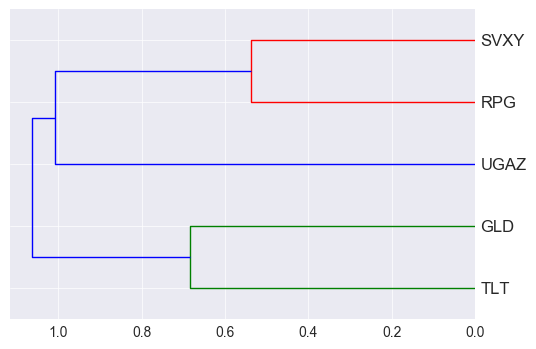

In [21]:
link = sch.linkage(correlDist(corr), 'single')
sch.dendrogram(link, labels=df_returns.columns, orientation='left')

# Returns Output

In [22]:
df_returns = df_px.pct_change()

if 'UGAZ' in df_returns.columns:
    df_returns['UGAZ'] *= -1               # Adjust for short sale
    df_returns['UGAZ'] -= .065/periodicity # Adjust for borrow cost
    df_returns['UGAZ'] *= -1               # Re-adjust for short sale

df_returns['MV'] = MV_returns*leverage - margin_rate*(max(leverage, 1)-1)/periodicity
df_returns['IV'] = IV_returns*leverage - margin_rate*(max(leverage, 1)-1)/periodicity
df_returns['IB'] = IB_returns*leverage - margin_rate*(max(leverage, 1)-1)/periodicity
df_returns['ERC'] = ERC_returns*leverage - margin_rate*(max(leverage, 1)-1)/periodicity
#df_returns['ERC_M'] = ERC_M_returns*leverage - margin_rate*(max(leverage, 1)-1)/periodicity
#df_returns['ERC+M'] = ERC_plus_M_returns*leverage - margin_rate*(max(leverage, 1)-1)/periodicity
#df_returns['MCRO'] = MCRO_returns*leverage - margin_rate*(max(leverage, 1)-1)/periodicity
df_returns['HRP'] = HRP_returns*leverage - margin_rate*(max(leverage, 1)-1)/periodicity
#df_returns['DRP'] = DRP_returns*leverage - margin_rate*(max(leverage, 1)-1)/periodicity

df_returns.insert(loc=0, column='VTI', value=df['VTI'].pct_change())
df_returns = df_returns.iloc[corr_lookback:]

In [23]:
to_summary(df_returns)

,VTI,RPG,SVXY,TLT,GLD,UGAZ,MV,IV,IB,ERC,HRP
Summary Stats:,,,,,,,,,,,
CAGR,9%,12%,33%,6%,4%,-81%,15%,31%,29%,30%,20%
MOIC,2.35x,2.98x,16.8x,1.86x,1.46x,0.00x,3.97x,14.6x,12.9x,14.1x,6.18x
Sharpe,0.43,0.53,0.52,0.42,0.20,-0.65,0.87,1.34,1.35,1.42,1.04
Sortino,0.67,0.83,0.77,0.71,0.32,-1.10,1.49,2.24,2.30,2.42,1.76
Skew,0.01,-0.02,-0.95,0.01,-0.04,0.30,0.15,-0.20,-0.08,-0.10,0.03
Max Drawdown,-53%,-51%,-83%,-27%,-46%,-100%,-29%,-38%,-31%,-30%,-25%
Ulcer Index,13.6,12.7,37.7,12.2,25.5,96.7,9.05,7.37,6.63,6.84,9.45
Ulcer Performance Index,0.66,0.91,0.87,0.53,0.15,-0.84,1.64,4.17,4.41,4.44,2.12
Monthly Perf. Metrics:,,,,,,,,,,,


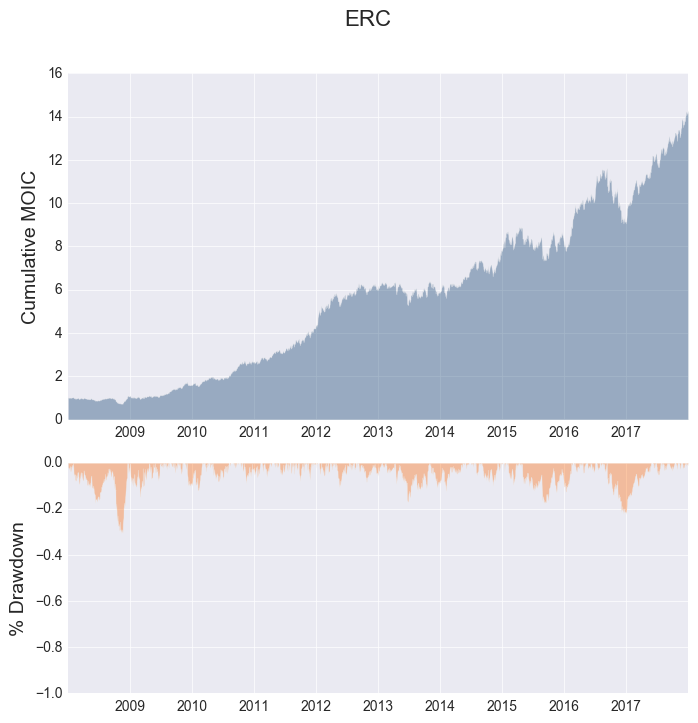

In [24]:
t1 = time.time()
plot_rets_dd(df_returns.iloc[-252*15:, -2], yscale='linear', sizex=8, sizey=8)

### Correlations

In [25]:
df_returnsM = np.cumprod(1+df_returns).resample('M').ffill().pct_change()[1:]
df_returnsM.corr(method='spearman').applymap(to_decimal)

,VTI,RPG,SVXY,TLT,GLD,UGAZ,MV,IV,IB,ERC,HRP
VTI,1.00,0.93,0.79,-0.33,-0.00,0.04,0.23,0.52,0.45,0.44,0.25
RPG,0.93,1.00,0.78,-0.29,0.05,0.03,0.32,0.56,0.49,0.47,0.31
SVXY,0.79,0.78,1.00,-0.39,-0.02,0.07,-0.03,0.49,0.40,0.39,0.15
TLT,-0.33,-0.29,-0.39,1.00,0.21,-0.07,0.59,0.24,0.37,0.38,0.55
GLD,-0.00,0.05,-0.02,0.21,1.00,-0.02,0.57,0.52,0.55,0.51,0.73
UGAZ,0.04,0.03,0.07,-0.07,-0.02,1.00,-0.08,-0.42,-0.38,-0.45,-0.12
MV,0.23,0.32,-0.03,0.59,0.57,-0.08,1.00,0.64,0.70,0.70,0.86
IV,0.52,0.56,0.49,0.24,0.52,-0.42,0.64,1.00,0.96,0.98,0.80
IB,0.45,0.49,0.40,0.37,0.55,-0.38,0.70,0.96,1.00,0.97,0.84
ERC,0.44,0.47,0.39,0.38,0.51,-0.45,0.70,0.98,0.97,1.00,0.84


### Monthly Return Pair Plots

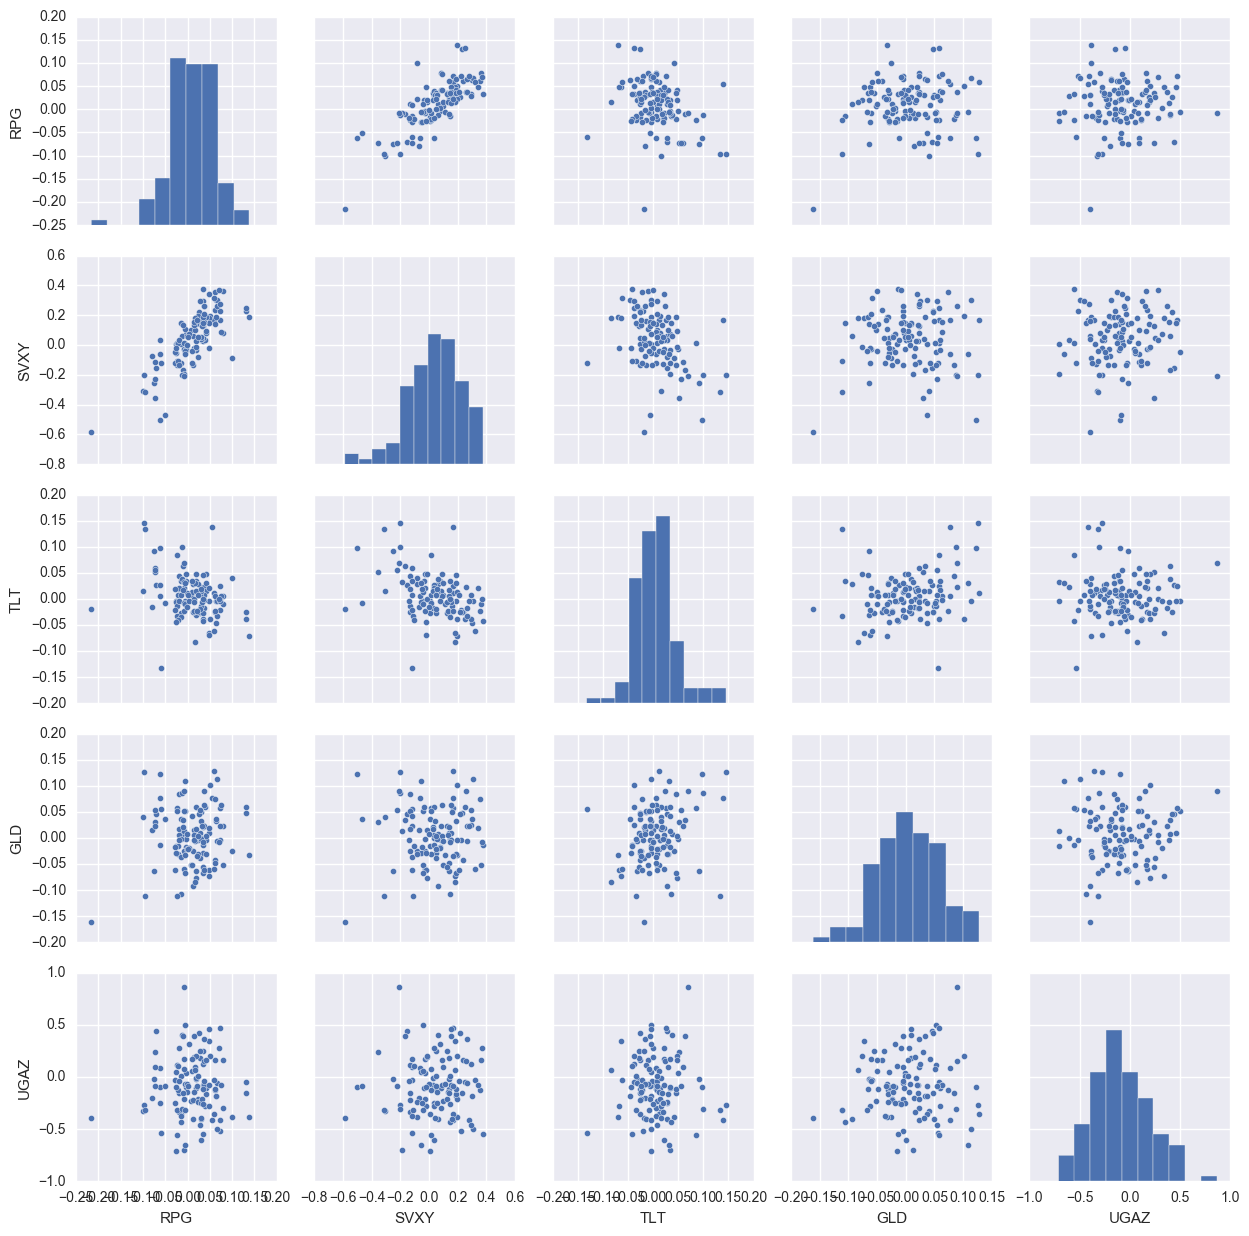

In [26]:
pairplot_tks = tickers.copy()
#sns.set(style="ticks")
sns.set(style="darkgrid")

df_sns = df_returns.loc[:, tuple(pairplot_tks)] 
df_snsM = df_sns.resample('M').apply(lambda x: np.prod(1+x)-1)

sns.pairplot(df_snsM)

### Individual & Monthly Returns

In [27]:
#------------------------------------
# Individual monthly returns
#------------------------------------
m_start_str = "Dec 2015"
m_end_str   = "Jan 2017"
((1+df_returnsM.loc[m_start_str:m_end_str])-1).applymap(to_percent)

,VTI,RPG,SVXY,TLT,GLD,UGAZ,MV,IV,IB,ERC,HRP
2015-12-31,-2%,-2%,-14%,-0%,-0%,-4%,-2%,-3%,-3%,-3%,-2%
2016-01-31,-6%,-7%,-22%,6%,5%,-8%,2%,1%,2%,3%,6%
2016-02-29,-0%,-1%,-6%,3%,11%,-66%,8%,18%,18%,17%,13%
2016-03-31,7%,7%,37%,-0%,-1%,28%,2%,4%,6%,4%,3%
2016-04-30,1%,-1%,1%,-1%,5%,8%,-0%,1%,1%,1%,1%
2016-05-31,2%,4%,21%,1%,-6%,-4%,-1%,2%,2%,1%,-0%
2016-06-30,0%,-1%,-21%,7%,9%,87%,9%,2%,3%,3%,10%
2016-07-31,4%,5%,34%,2%,2%,-7%,5%,9%,9%,9%,6%
2016-08-31,0%,-1%,11%,-1%,-3%,-7%,-4%,-1%,-2%,-2%,-3%
2016-09-30,0%,-0%,0%,-2%,1%,-7%,-2%,-1%,-1%,-1%,-1%


In [28]:
#------------------------------------
# Cumulative monthly returns
#------------------------------------
(np.cumprod(1+df_returnsM.loc[m_start_str:m_end_str])-1).applymap(to_percent)

,VTI,RPG,SVXY,TLT,GLD,UGAZ,MV,IV,IB,ERC,HRP
2015-12-31,-2%,-2%,-14%,-0%,-0%,-4%,-2%,-3%,-3%,-3%,-2%
2016-01-31,-8%,-9%,-33%,5%,5%,-12%,0%,-2%,-1%,-1%,4%
2016-02-29,-8%,-10%,-37%,9%,16%,-70%,8%,15%,16%,16%,17%
2016-03-31,-1%,-3%,-14%,8%,15%,-61%,11%,20%,24%,20%,20%
2016-04-30,-1%,-4%,-12%,8%,21%,-58%,11%,21%,25%,21%,22%
2016-05-31,1%,-1%,6%,9%,14%,-60%,10%,23%,27%,23%,21%
2016-06-30,1%,-1%,-16%,16%,24%,-25%,20%,25%,31%,27%,33%
2016-07-31,6%,3%,12%,19%,27%,-30%,26%,37%,43%,38%,41%
2016-08-31,6%,3%,25%,17%,22%,-35%,21%,35%,40%,35%,37%
2016-09-30,6%,3%,25%,16%,23%,-39%,19%,34%,38%,34%,35%


### Portfolio Weight Plots

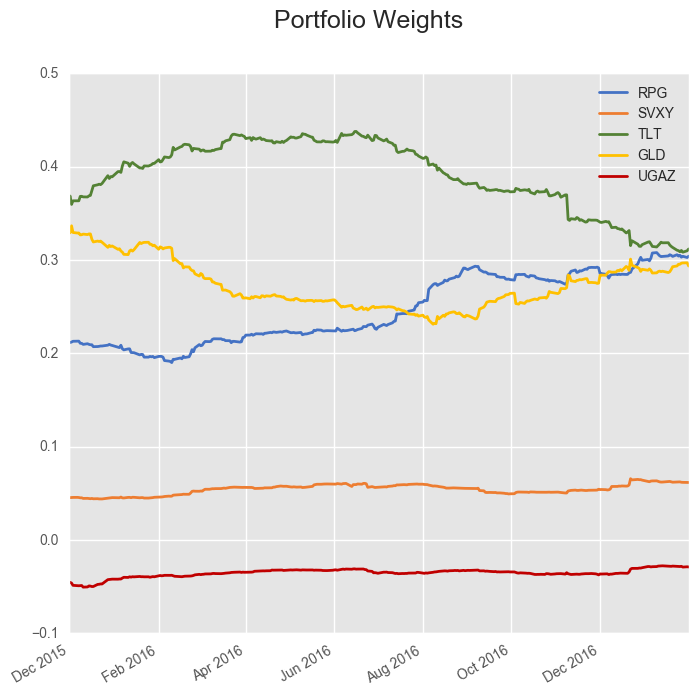

In [29]:
sns.set_style('darkgrid')
plt.style.use('ggplot')
plt.figure()
plt.rcParams['figure.figsize'] = (8, 8)

colors = [(68/255, 114/255, 196/255),
          (237/255, 125/255, 49/255),
          (84/255, 130/255, 53/255),
          (255/255, 192/255, 0),
          (192/255, 0, 0),
          (165/255, 165/255, 165/255),
          (91/255, 155/255, 213/255),
          (68/255, 84/255, 106/255)]

df_ERC_weights.loc[m_start_str:m_end_str].plot(linewidth=2.0, color=colors)
plt.legend(loc='best')
plt.suptitle('Portfolio Weights', fontsize=18)
axes = plt.gca()

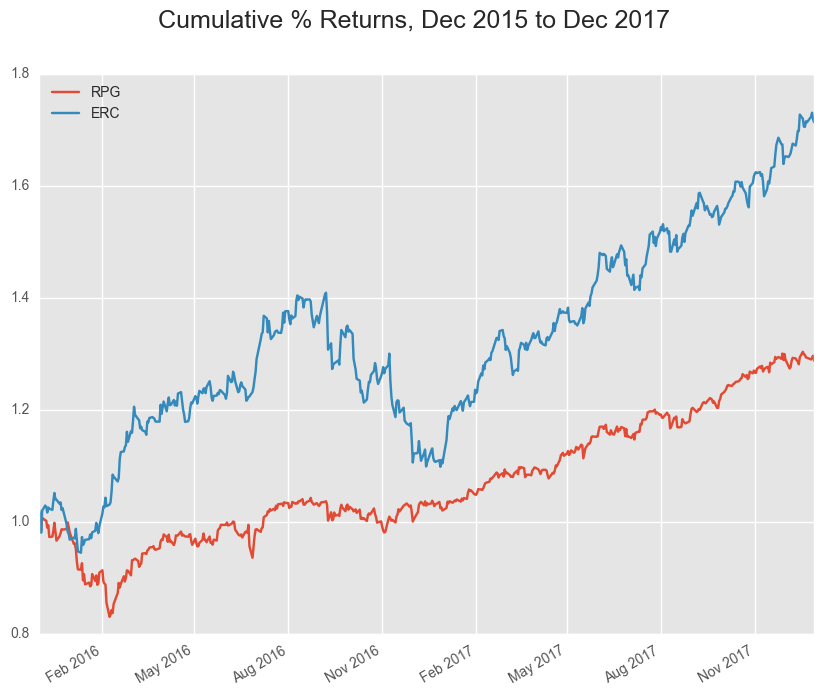

In [30]:
plt_start = 'Dec 2015'
plt_end   = 'Dec 2017'
plt.figure()
plt.rcParams['figure.figsize'] = (10, 8)
np.cumprod(1+df_returns.loc[plt_start:plt_end, ('RPG','ERC')]).plot()
plt.legend(loc='best')
#plt.yscale('log')
plt.suptitle('Cumulative % Returns, {0} to {1}'.format(plt_start, plt_end), fontsize=18)

# Security Selection

### Global Minimum Variance Framework

In [31]:
#----------------------------------
# Extract securities to target minimum portfolio variance
#----------------------------------
# Initial round
t1 = time.time()
df_returns2 = df.pct_change(1)[1:]

if 'UGAZ' in df_returns2.columns:
    df_returns2['UGAZ'] *= -1               # Adjust for short sale
    df_returns2['UGAZ'] -= .065/periodicity # Adjust for borrow cost

MV_tickers = ['SVXY']
df_returns3 = df_returns2.drop(MV_tickers, axis=1)
iter_limit = 5
sel_lookback = 252*20

iters = len(MV_tickers)
while iters < iter_limit:
    min_port_var = 10**6
    min_port_var_tick = ''

    for tick in df_returns3.columns:
        MV_tickers.append(tick)
        n_MV_tickers = len(MV_tickers)
        x0 = np.ones([n_MV_tickers, 1])/n_MV_tickers
        y0 = np.append(x0, newt_lambda0).reshape(-1, 1)
        
        returns_array = np.array(df_returns2[MV_tickers][-sel_lookback:])*1000
        omega = np.cov(returns_array.T)
        w = min_var(returns_array, MV_lambda)
        port_var = (w.T @ omega @ w)[0, 0]
        if port_var < min_port_var:
            min_port_var = port_var
            min_port_var_tick = tick

        MV_tickers.remove(tick)

    MV_tickers.append(min_port_var_tick)
    df_returns3 = df_returns3.drop(min_port_var_tick, axis=1)
    iters += 1
    
print('{0:,.3f}'.format(time.time()-t1), 'seconds')
print("Tickers:", MV_tickers)

0.126 seconds
Tickers: ['SVXY', 'VMBS', 'SRLN', 'CWB', 'EMB']


### Inverse Vol Weights; Max CAGR & Ulcer Performance Index

In [32]:
#----------------------------------
# Extract securities to target maximum ulcer performance index + CAGR
#----------------------------------
# Initial round
t1 = time.time()
df_returns2 = df.pct_change(1)[1:]

IV_tickers = ['SVXY'] # Input first x tickers (must be less than 'iter_limit' below) around which to build portfolio
df_returns3 = df_returns2.drop(IV_tickers, axis=1)
iter_limit = 5
tot_lookback = 252*20
vol_lookback = 252

iters = len(IV_tickers)
while iters < iter_limit:
    min_cross_ent = -10**4
    best_tick = ''

    for tick in tqdm(df_returns3.columns):
        IV_tickers.append(tick)
        df_returns4 = df_returns2[IV_tickers][-tot_lookback:]
        
        if 'UGAZ' in IV_tickers:
            df_returns4['UGAZ'] *= -1               # Adjust for short sale
            df_returns4['UGAZ'] -= .065/periodicity # Adjust for borrow cost
        
        df_RV_sel = np.sqrt(periodicity/vol_lookback*(np.log(1+df_returns4)**2).rolling(vol_lookback).sum())*100
        arr_IV_sel = np.array(1/df_RV_sel)
        IV_wt_arr_sel = arr_IV_sel/arr_IV_sel.sum(axis=1).reshape(-1, 1)
        df_IV_sel_weights = pd.DataFrame(index=df_RV_sel.index, columns=df_RV_sel.columns, data=IV_wt_arr_sel)
            
        if 'UGAZ' in IV_tickers:
            df_returns4['UGAZ'] *= -1               # Re-adjust for short sale
            df_IV_sel_weights['UGAZ'] *= -1
            
        IV_returns_sel = (df_IV_sel_weights.shift(1)*df_returns4).sum(axis=1)
        MOIC = np.prod(1+IV_returns_sel)
        CAGR = MOIC**(periodicity/len(IV_returns_sel))-1
        ulcer_index = np.sqrt(np.sum((np.cumprod(1+IV_returns_sel)\
                                      /np.maximum.accumulate(np.cumprod(1+IV_returns_sel))-1)**2)\
                              /len(IV_returns_sel))*100
        
        gain_to_pain = -np.sum(IV_returns_sel)/np.sum(np.clip(IV_returns_sel, a_max=0, a_min=None))
        sortino = CAGR/(np.std(np.clip(IV_returns_sel, a_max=0, a_min=None))*np.sqrt(periodicity))
        
        ulcer_perf = CAGR/ulcer_index*100
        cross_ent = 1*np.log(CAGR) + 1*np.log(ulcer_perf)# + 0*np.log(gain_to_pain) + 1*np.log(sortino)
        if cross_ent > min_cross_ent:
            min_cross_ent = cross_ent
            best_tick = tick
        
        IV_tickers.remove(tick)
        
    IV_tickers.append(best_tick)
    df_returns3 = df_returns3.drop(best_tick, axis=1)
    iters += 1

print('{0:,.3f}'.format(time.time()-t1), 'seconds')
print("Tickers:", IV_tickers)

100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:01<00:00, 15.64it/s]


3.590 seconds
Tickers: ['SVXY', 'UGAZ', 'TLT', 'RPG', 'GLD']
